In [1]:
import numpy as np
import xarray as xr
import netCDF4
import os
import math
import datetime
import matplotlib.pyplot as plt 
import scipy.stats as sstats
from scipy.stats.sampling import DiscreteAliasUrn
from matplotlib import cm
import random
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import numpy
%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import IPython.display
import json
import sys
import yaml
from random import randrange
from functions_gapfill import *

In [2]:
# we want to introdce 10% missing data at locations X and 
# 24, 48,72,96

# Gapfilling the AWS of the LéXPLORE platform

In this notebook we use the G2S server with Direct Sampling approach (https://gaia-unil.github.io/G2S/briefOverview.html) to fill the data gaps of the meteo station or AWS of the LéXPLORE platform (https://gitlab.renkulab.io/lexplore).

See other notebooks in this repository on how to arrive at this point. 

We use already 1 hourly aggregated values of the meteo station and we fill gaps for the following variables on 1 hour resolution:

* Air temperature

* Baromatric pressure 

* Relative Humidity

* Wind Speed

* Wind Direction

* Wind Gusts

* Precipitation

* Solar Incoming Radiation 

* Solar Total Incoming Radation (PROBABLY NOT)

To do so, we use independent data as co-variates, namely variables from the closest gridpoint in ERA5 and ERA5-land. Other potential co-variates could be AWS data from other locations around Lake Geneva or data from other weather models or reconstructions. 

## Activate G2S server

In [3]:
#!pip install G2S libtiff --quiet
from g2s import g2s
g2s('--version')


G2S version 0.98.015, compiled the Dec 17 2022 16:39:25 with Python 3.11.1


In [4]:
#! git clone https://github.com/GAIA-UNIL/G2S.git --quiet

In [5]:
#%%capture
#!export NVFLAGS='-gencode=arch=compute_35,code=sm_35 -gencode=arch=compute_37,code=sm_37 -gencode=arch=compute_50,code=sm_50 -gencode=arch=compute_52,code=sm_52 -gencode=arch=compute_60,code=sm_60 -gencode=arch=compute_61,code=sm_61 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_70,code=compute_70'
#!sudo apt -qq install build-essential libzmq3-dev libjsoncpp-dev zlib1g-dev libfftw3-dev libcurl4-openssl-dev -y
#!sudo wget -q "https://raw.githubusercontent.com/zeromq/cppzmq/master/zmq.hpp" -O /usr/include/zmq.hpp
#!( cd G2S/build && make c++ -j --silent)
#!bash G2S/build/c++-build/install_needs_W_VM.sh

In [6]:
!pwd

/home/mwegmann/g2s/notebooks


In [7]:
os.chdir("/home/mwegmann/g2s")

In [8]:
!bash -c "cd G2S/build/c++-build/ && ./server -d"


start daemon


In [9]:
ti = numpy.array(Image.open(BytesIO(requests.get('https://raw.githubusercontent.com/GAIA-UNIL/TrainingImagesTIFF/master/stone.tiff').content)));

In [10]:
a=g2s('-a','echo','-ti',ti,'-dt',[0])

job Id is: 2900448534
progress 100.000%      
        

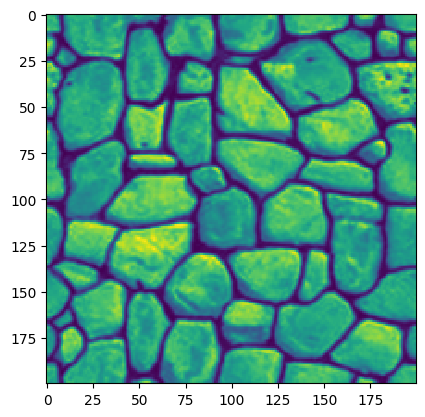

In [11]:
plt.imshow(a[0], interpolation='nearest')

## folder setup

In [12]:
# change yaml location here
with open(r"/home/mwegmann/g2s/notebooks/folder_gap_filling.yaml", "r") as f:
    directories = yaml.load(f, Loader=yaml.FullLoader)

In [13]:
#for d in directories.values():
#    if not os.path.exists(d):
#        os.makedirs(d)

In [14]:
# defining folders
input_folder=directories["g2s_input_folder"]

output_folder=directories["g2s_output_folder"]

scripts_folder=directories["scripts_folder"]

## Direct Sampling Coefficients

In [15]:
amount_member=50
test_runs=5

## read in data

In [16]:
meteo_orig=xr.open_dataset(input_folder+"meteo_1hr_g2s.nc")

In [17]:
meteo_orig

<xarray.Dataset>
Dimensions:   (time: 26280)
Coordinates:
  * time      (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    AirTC     (time) float64 ...
    RH        (time) float64 ...
    Slrw      (time) float64 ...
    WS        (time) float64 ...
    WindDir   (time) float64 ...
    Rain      (time) float64 ...
    BP        (time) float64 ...
    WindGust  (time) float64 ...

In [18]:
era5=xr.open_dataset(input_folder+"era5_lexplore_g2s.nc")

In [19]:
era5

<xarray.Dataset>
Dimensions:    (time: 26280)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * time       (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    u10        (time) float32 ...
    v10        (time) float32 ...
    t2m        (time) float32 ...
    sp         (time) float32 ...
    ssrd       (time) float32 ...
    tp         (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-05 18:55:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [20]:
era5_land=xr.open_dataset(input_folder+"era5_land_lexplore_g2s.nc")

In [21]:
era5_land

<xarray.Dataset>
Dimensions:    (time: 26280)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * time       (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    sp         (time) float32 ...
    ssrd       (time) float32 ...
    t2m        (time) float32 ...
    tp         (time) float32 ...
    u10        (time) float32 ...
    v10        (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-13 10:24:45 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [22]:
from scipy import signal

In [23]:
fs=1/(60*60)

In [24]:
x=era5_land.t2m.values[:5000]

In [25]:
x_alt=era5_land.t2m.values[10000:15000]

In [26]:
f, Pxx_den = signal.periodogram(x, fs)

In [27]:
f_alt, Pxx_den_alt = signal.periodogram(x_alt, fs)

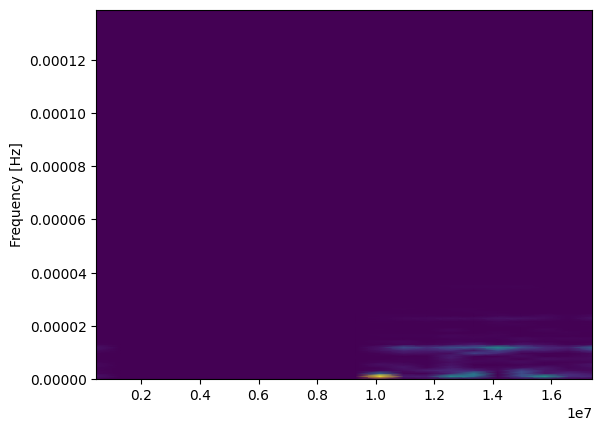

In [28]:
f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('')
plt.show()

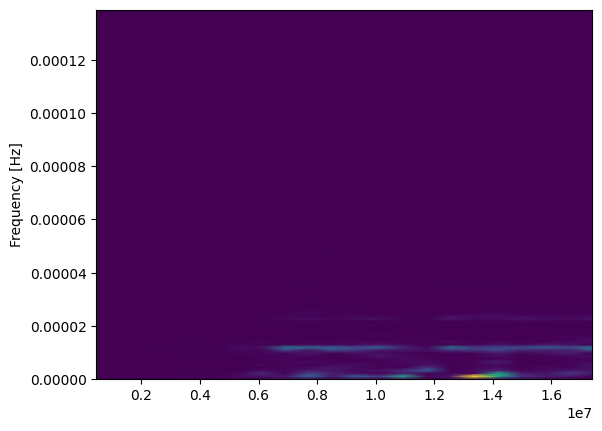

In [29]:
f, t, Sxx = signal.spectrogram(x_alt, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('')
plt.show()

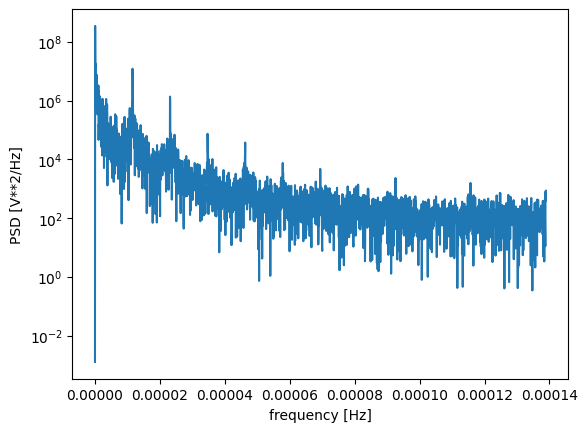

In [30]:

plt.semilogy(f_alt, Pxx_den_alt)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

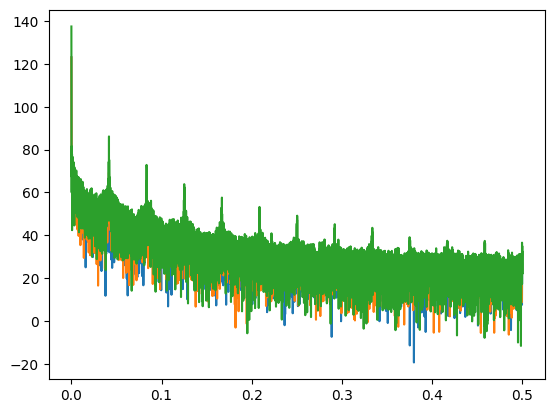

In [31]:
from scipy import fftpack

fs = 1 / (365*24) # hourly
N = len(era5_land.t2m.values[:5000])
spectrum = fftpack.fft(era5_land.t2m.values[:5000])
freqs = fftpack.fftfreq(len(spectrum)) #* fs

plt.plot(freqs[:N//2], 20 * np.log10(np.abs(spectrum[:N//2])))

N = len(era5_land.t2m.values[10000:15000])
spectrum = fftpack.fft(era5_land.t2m.values[10000:15000])
freqs = fftpack.fftfreq(len(spectrum)) #* fs

plt.plot(freqs[:N//2], 20 * np.log10(np.abs(spectrum[:N//2])))

N = len(era5_land.t2m.values)
spectrum = fftpack.fft(era5_land.t2m.values)
freqs = fftpack.fftfreq(len(spectrum)) #* fs

plt.plot(freqs[:N//2], 20 * np.log10(np.abs(spectrum[:N//2])))

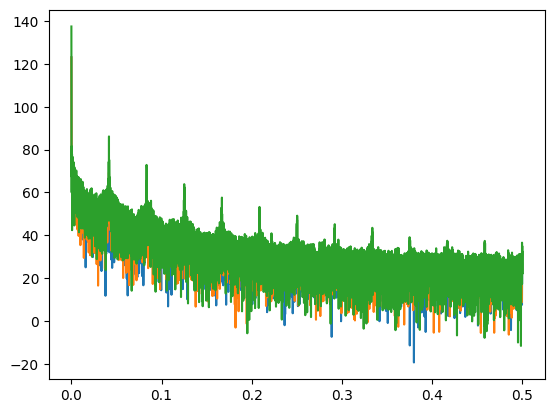

In [32]:
from scipy import fftpack

fs = 1 / 24 # hourly
N = len(era5_land.t2m.values[:5000])
spectrum = fftpack.fft(era5_land.t2m.values[:5000])
freqs = fftpack.fftfreq(len(spectrum)) #* fs

plt.plot(freqs[:N//2], 20 * np.log10(np.abs(spectrum[:N//2])))

N = len(era5_land.t2m.values[10000:15000])
spectrum = fftpack.fft(era5_land.t2m.values[10000:15000])
freqs = fftpack.fftfreq(len(spectrum)) #* fs

plt.plot(freqs[:N//2], 20 * np.log10(np.abs(spectrum[:N//2])))

N = len(era5_land.t2m.values)
spectrum = fftpack.fft(era5_land.t2m.values)
freqs = fftpack.fftfreq(len(spectrum)) #* fs

plt.plot(freqs[:N//2], 20 * np.log10(np.abs(spectrum[:N//2])))

In [33]:
import xwavelet as xw

In [34]:
result = xw.wavelet(era5_land.t2m)

/home/mwegmann/anaconda3/envs/g2s/lib/python3.11/site-packages/xwavelet/xrtools.py:181: UserWarning: Unknown time frequency. Using default dt=1.
  warnings.warn("Unknown time frequency. Using default dt=1.")


In [35]:
result_2 = xw.wavelet(era5_land.t2m[:5000])

/home/mwegmann/anaconda3/envs/g2s/lib/python3.11/site-packages/xwavelet/xrtools.py:181: UserWarning: Unknown time frequency. Using default dt=1.
  warnings.warn("Unknown time frequency. Using default dt=1.")


In [36]:
result_3 = xw.wavelet(era5_land.t2m[5001:10000])

/home/mwegmann/anaconda3/envs/g2s/lib/python3.11/site-packages/xwavelet/xrtools.py:181: UserWarning: Unknown time frequency. Using default dt=1.
  warnings.warn("Unknown time frequency. Using default dt=1.")


In [37]:
result_4 = xw.wavelet(meteo_orig.AirTC[0:350])

/home/mwegmann/anaconda3/envs/g2s/lib/python3.11/site-packages/xwavelet/xrtools.py:181: UserWarning: Unknown time frequency. Using default dt=1.
  warnings.warn("Unknown time frequency. Using default dt=1.")


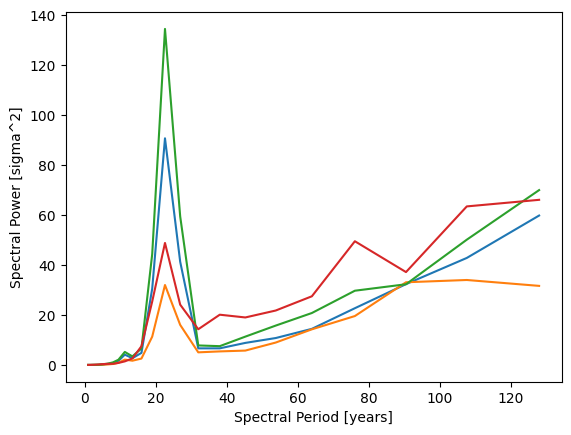

In [38]:
result.spectrum.plot()
result_2.spectrum.plot()
result_3.spectrum.plot()
result_4.spectrum.plot()


## Fill Air Temperature Data

### understand the average gap size in data

In [39]:
meteo_orig_airtc = meteo_orig.AirTC


In [40]:
compute_gap_sizes(meteo_orig_airtc)

array([ 48,  24,  72,  24, 156,  48,  96,  24,  24,  72, 168,   1,  96,
        16,   4,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1])

meteo_orig_airtc has 931 nans in 26280 data points
meteo_orig_airtc has 3.5426179604261794% missing values
meteo_orig_airtc has 73 gaps with 1.0 median gap size
meteo_orig_airtc has 73 gaps with 12.753424657534246 mean gap size


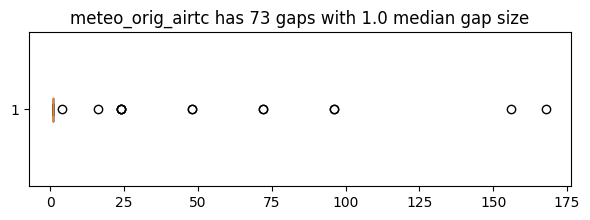

In [41]:
gap_info(meteo_orig_airtc, "meteo_orig_airtc")

In [42]:
np.isnan(meteo_orig_airtc.values).sum()

931

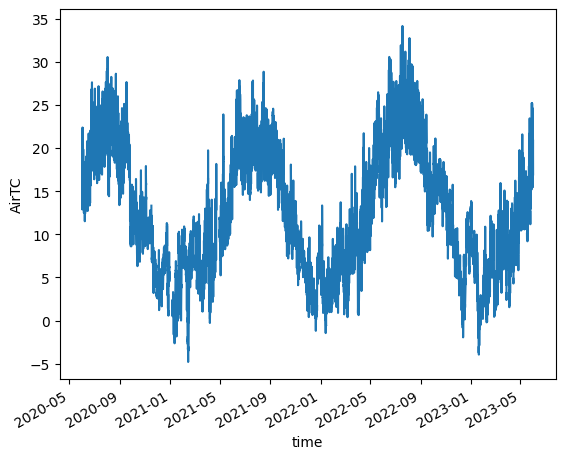

In [43]:
meteo_orig_airtc.plot()

### create replicable gaps

The idea is to create gaps that are always at the same position, but different in size.

It is tricky to think about a "perfect gap size" that we should try out. I would suggest that we try out gap sizes from 1 day (24 missing values in the case of the meteo station) towards 4 days (96 missing values in case of the meteo station).

The other question is how many (in %) new missing values do we introduce to evaluate our routine. The meteo station has 3% missing data as it is. Is 10% a good metric to evaluate? 20%?

In [44]:
gap_sizes = compute_gap_sizes(meteo_orig_airtc) #number and size of gaps
gap_sizes

array([ 48,  24,  72,  24, 156,  48,  96,  24,  24,  72, 168,   1,  96,
        16,   4,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1])

In [45]:
gap_sizes[gap_sizes>24] = 24
gap_sizes

array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,  1, 24, 16,  4,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

In [46]:
new_var=meteo_orig_airtc.copy()

In [47]:
len_new_var=new_var.data.size
gap_amount_per=10
gap_len=24
gap_amount_num=int(np.round(gap_amount_per/100*len_new_var))
gap_number=int(np.round(gap_amount_num/gap_len))

gap_location=[]
for i in range(gap_number):
    gap_location.append(randrange(len_new_var))

In [48]:
gap_locations=create_gap_index(da=meteo_orig_airtc,gap_percent=11,gap_length=24)

In [49]:
gap_locations_5=create_gap_index(da=meteo_orig_airtc,gap_percent=6,gap_length=24)

In [50]:
meteo_gapped_airtc_24_10=create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=24,selector=1)

Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :3486
% NAs in new :13.264840182648403
9.722222222222223


In [51]:
meteo_gapped_airtc_24_5=create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations_5,gap_length=24,selector=1)

Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2425
% NAs in new :9.227549467275495
5.684931506849315


In [52]:
meteo_gapped_airtc_48_10=create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=48,selector=2)

Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :3549
% NAs in new :13.504566210045663
9.961948249619484


In [53]:
create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=48,selector=2)

Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :3549
% NAs in new :13.504566210045663
9.961948249619484


<xarray.DataArray 'AirTC' (time: 26280)>
array([15.576667, 14.49    , 13.751667, ..., 18.471667, 17.726667, 16.955   ])
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00

In [54]:
create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=72,selector=3)

Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :3519
% NAs in new :13.39041095890411
9.84779299847793


<xarray.DataArray 'AirTC' (time: 26280)>
array([15.576667, 14.49    , 13.751667, ..., 18.471667, 17.726667, 16.955   ])
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00

In [55]:
create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=96,selector=4)

Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :3666
% NAs in new :13.949771689497718
10.407153729071537


<xarray.DataArray 'AirTC' (time: 26280)>
array([15.576667, 14.49    , 13.751667, ..., 18.471667, 17.726667, 16.955   ])
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00

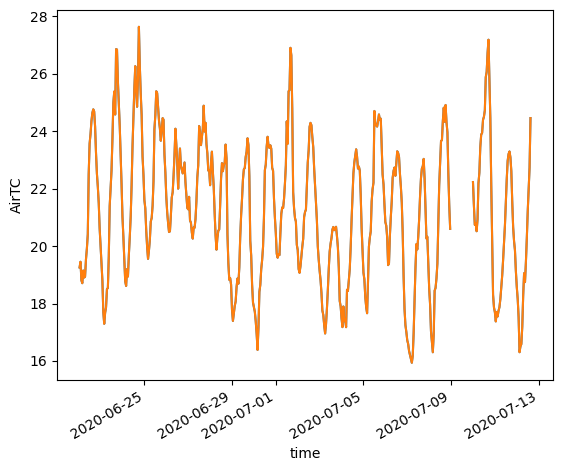

In [56]:

meteo_orig_airtc[505:1000].plot()
meteo_gapped_airtc_24_10[505:1000].plot()


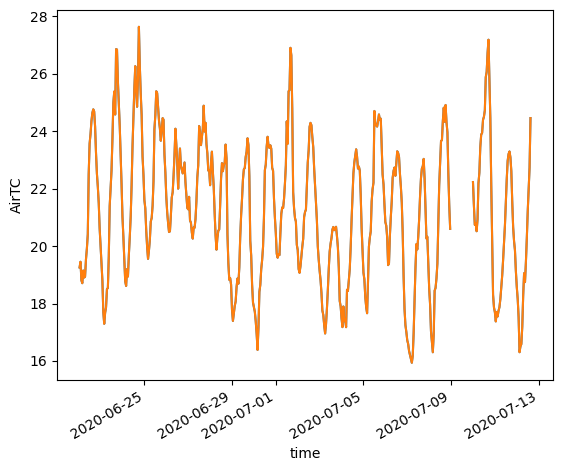

In [57]:

meteo_orig_airtc[505:1000].plot()
meteo_gapped_airtc_48_10[505:1000].plot()


## Run gapfilling

In [58]:

gap_amount_list=[24,48,72,96]
selector_list=[1,2,3,4]
#gap_amount_list=[150]
N = amount_member
runs=test_runs


In [59]:
gapped_data=meteo_gapped_airtc_24_10
original = meteo_orig_airtc
L = gapped_data.data.size
sin_calendar = sin_costfunction(L,daily_timesteps = 24)
cos_calendar = cos_costfunction(L,daily_timesteps = 24)
timeofday = meteo_orig_airtc.time.dt.hour.values #Ca

In [60]:
gapped_data_temp=gapped_data.copy()

In [61]:
#Univariate gap-filling
ti = gapped_data.data
di = gapped_data.data
dt = [0]

UV_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
UV_simulations = xr.DataArray(data =UV_stacked,coords = {'realizations':np.arange(1,UV_stacked.shape[0]+1),'time':gapped_data.time})

job Id is: 3758322455
progress 100.000%       
        job Id is: 2683304282
progress 100.000%       
        job Id is: 1617311096
progress 100.000%       
        job Id is: 4234075651
progress 100.000%       
        job Id is: 3161643836
progress 100.000%       
        job Id is: 1477489092
progress 100.000%       
        job Id is: 398175905
progress 100.000%       
        job Id is: 3003458247
progress 100.000%       
        job Id is: 2550900261
progress 100.000%       
        job Id is: 1469212152
progress 100.000%       
        job Id is: 382526022
progress 100.000%       
        job Id is: 4268438803
progress 100.000%       
        job Id is: 1952211589
progress 100.000%       
        job Id is: 2105536896
progress 100.000%       
        job Id is: 1640257428
progress 100.000%       
        job Id is: 566735935
progress 100.000%       
        job Id is: 3176002259
progress 100.000%       
        job Id is: 2720450258
progress 100.000%       
        job Id is: 16

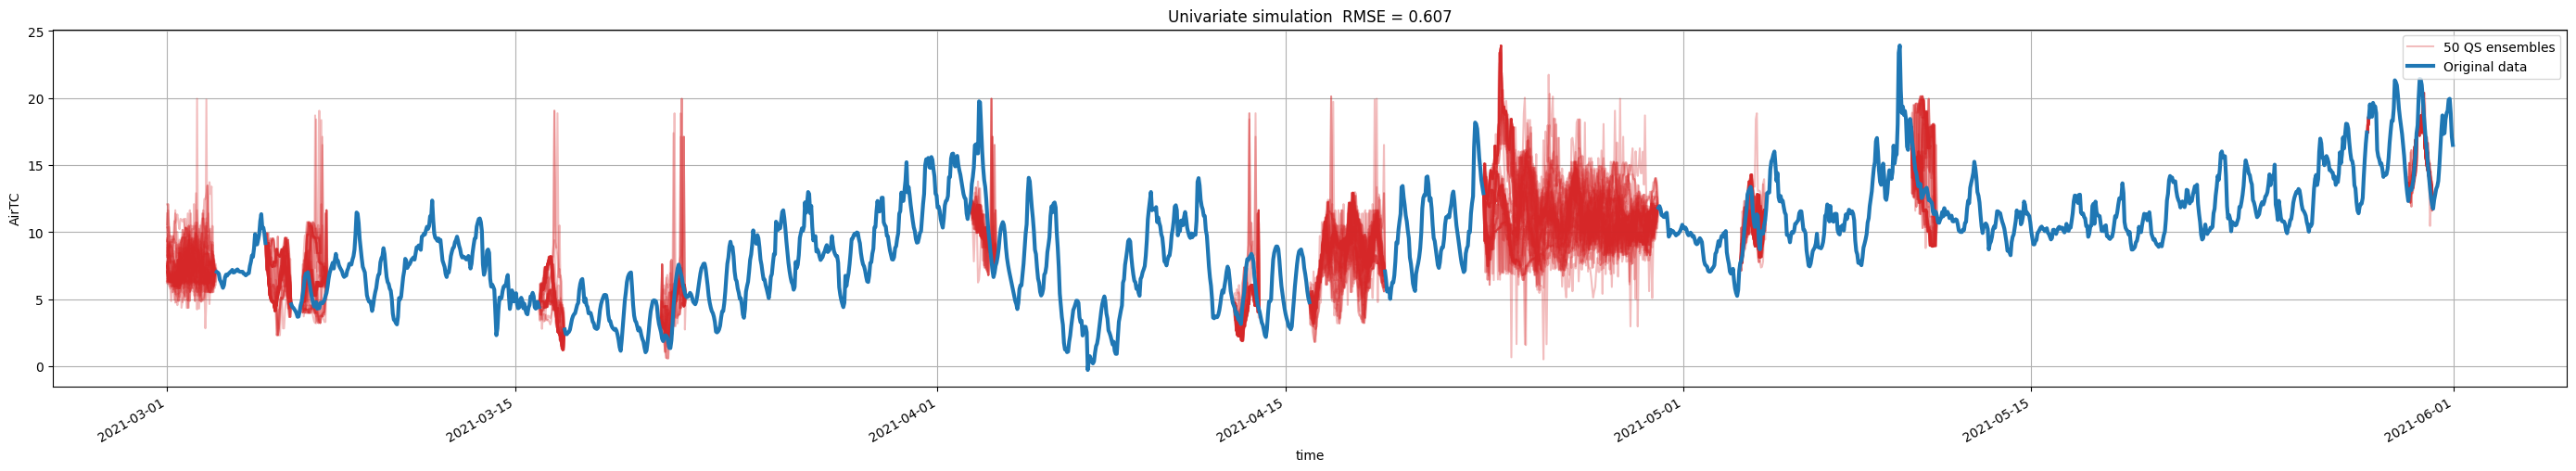

In [62]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = original,
                   simulation = UV_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Univariate simulation ')

In [63]:
corr=np.round(xr.corr(original, UV_simulations, dim="time").mean(dim="realizations").values,4)
error = np.round(np.sqrt(np.nanmean((UV_simulations.data-original.data)**2)),4)
std_ratio=(original/UV_simulations).mean(dim="realizations").mean(dim="time").values

In [64]:
print(corr)
print(error)
print(std_ratio)

0.9963
0.6065
1.0040529647262624


In [65]:
gapped_data=meteo_gapped_airtc_24_5
original = meteo_orig_airtc
L = gapped_data.data.size
sin_calendar = sin_costfunction(L,daily_timesteps = 24)
cos_calendar = cos_costfunction(L,daily_timesteps = 24)
timeofday = meteo_orig_airtc.time.dt.hour.values #Ca

In [66]:
#Univariate gap-filling
ti = gapped_data.data
di = gapped_data.data
dt = [0]

UV_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
UV_simulations = xr.DataArray(data =UV_stacked,coords = {'realizations':np.arange(1,UV_stacked.shape[0]+1),'time':gapped_data.time})

job Id is: 1187950681
progress 100.000%       
        job Id is: 3781334470
progress 100.000%       
        job Id is: 1480096469
progress 100.000%       
        job Id is: 3474432740
progress 100.000%       
        job Id is: 1179726633
progress 100.000%       
        job Id is: 3171321056
progress 100.000%       
        job Id is: 870856833
progress 100.000%       
        job Id is: 3482955416
progress 100.000%       
        job Id is: 1792829249
progress 100.000%       
        job Id is: 3783630386
progress 100.000%       
        job Id is: 1482888316
progress 100.000%       
        job Id is: 3466129910
progress 100.000%       
        job Id is: 1778991805
progress 100.000%       
        job Id is: 3770524415
progress 100.000%       
        job Id is: 1463942343
progress 100.000%       
        job Id is: 3455374984
progress 100.000%       
        job Id is: 1150734032
progress 100.000%       
        job Id is: 3143377868
progress 100.000%       
        job Id is: 

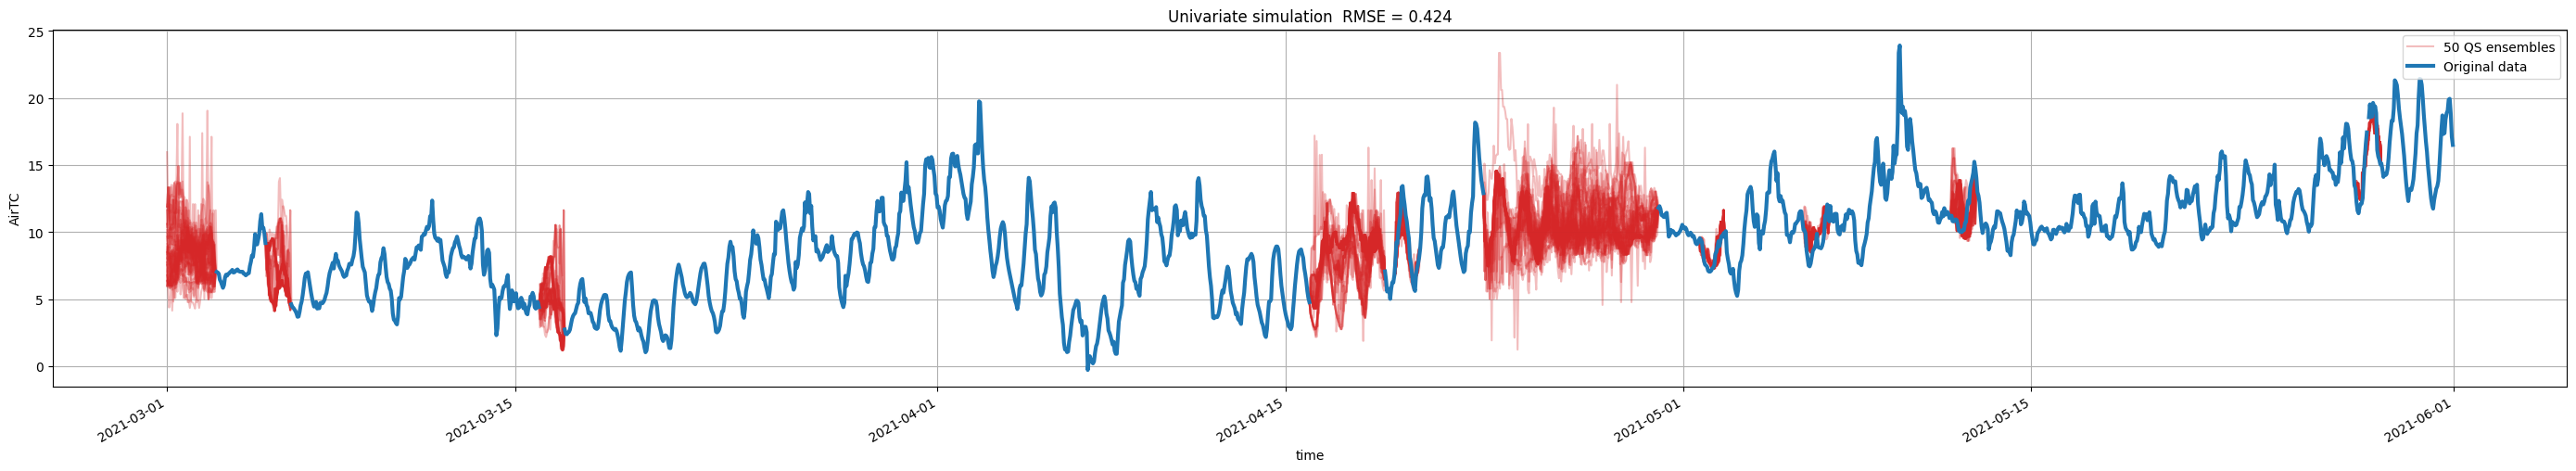

In [67]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = original,
                   simulation = UV_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Univariate simulation ')

In [68]:
corr=np.round(xr.corr(original, UV_simulations, dim="time").mean(dim="realizations").values,4)
error = np.round(np.sqrt(np.nanmean((UV_simulations.data-original.data)**2)),4)
std_ratio=(original/UV_simulations).mean(dim="realizations").mean(dim="time").values

In [69]:
print(corr)
print(error)
print(std_ratio)

0.9982
0.4238
1.0010031681801173


In [70]:
gapped_data=meteo_gapped_airtc_48_10
original = meteo_orig_airtc
L = gapped_data.data.size
sin_calendar = sin_costfunction(L,daily_timesteps = 24)
cos_calendar = cos_costfunction(L,daily_timesteps = 24)
timeofday = meteo_orig_airtc.time.dt.hour.values #Ca

In [71]:
#Univariate gap-filling
ti = gapped_data.data
di = gapped_data.data
dt = [0]

UV_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
UV_simulations = xr.DataArray(data =UV_stacked,coords = {'realizations':np.arange(1,UV_stacked.shape[0]+1),'time':gapped_data.time})

job Id is: 4221643644
progress 100.000%       
        job Id is: 3147376567
progress 100.000%       
        job Id is: 2081779471
progress 100.000%       
        job Id is: 1000649244
progress 100.000%       
        job Id is: 4229043780
progress 100.000%       
        job Id is: 3152395285
progress 100.000%       
        job Id is: 2078227266
progress 100.000%       
        job Id is: 1004204346
progress 100.000%       
        job Id is: 4215793571
progress 100.000%       
        job Id is: 3148770316
progress 100.000%       
        job Id is: 2075877045
progress 100.000%       
        job Id is: 1015899789
progress 100.000%       
        job Id is: 4232598657
progress 100.000%       
        job Id is: 3163934193
progress 100.000%       
        job Id is: 2095332877
progress 100.000%       
        job Id is: 1018864421
progress 100.000%       
        job Id is: 4237298226
progress 100.000%       
        job Id is: 3164987429
progress 100.000%       
        job Id is:

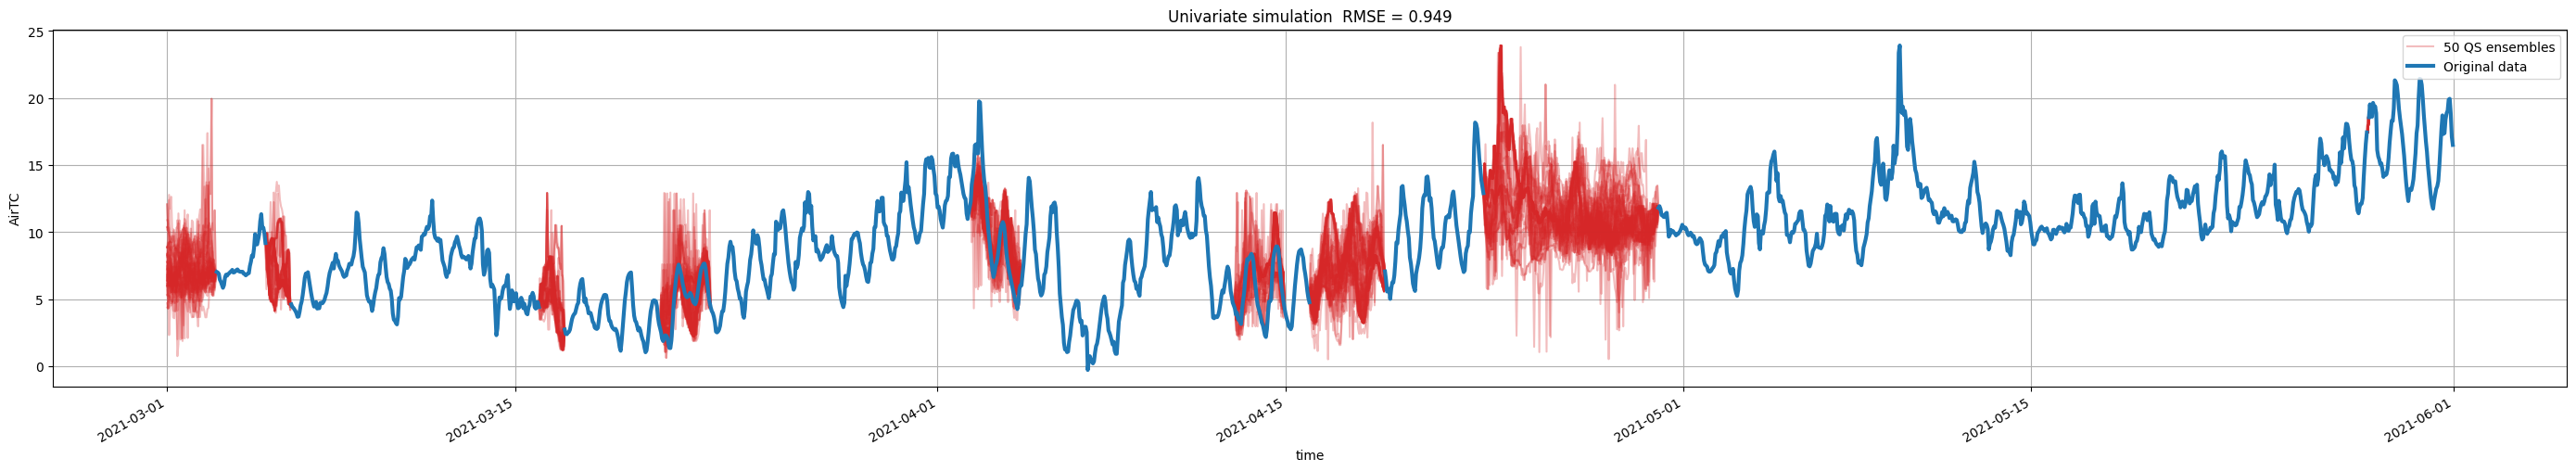

In [72]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = original,
                   simulation = UV_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Univariate simulation ')

In [73]:
corr=np.round(xr.corr(original, UV_simulations, dim="time").mean(dim="realizations").values,4)
error = np.round(np.sqrt(np.nanmean((UV_simulations.data-original.data)**2)),4)
std_ratio=(original/UV_simulations).mean(dim="realizations").mean(dim="time").values

In [74]:
print(corr)
print(error)
print(std_ratio)

0.991
0.9492
0.9996959525613889


In [75]:
gapped_data, gap_indices = create_gaps(original,gap_number = 24)

In [76]:
np.isnan(gapped_data.values).sum()

1020

In [77]:
np.isnan(gapped_data_temp.values).sum()

3486

In [78]:
#Univariate gap-filling
ti = gapped_data.data
di = gapped_data.data
dt = [0]

UV_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
UV_simulations = xr.DataArray(data =UV_stacked,coords = {'realizations':np.arange(1,UV_stacked.shape[0]+1),'time':gapped_data.time})

job Id is: 1995369640
progress 100.000%       
        job Id is: 3348558551
progress 100.000%       
        job Id is: 407833043
progress 100.000%       
        job Id is: 1763296905
progress 100.000%       
        job Id is: 3124457842
progress 100.000%       
        job Id is: 186587139
progress 100.000%       
        job Id is: 1542010723
progress 100.000%       
        job Id is: 2912555376
progress 100.000%       
        job Id is: 4266296497
progress 100.000%       
        job Id is: 1330627900
progress 100.000%       
        job Id is: 2687454653
progress 100.000%       
        job Id is: 4046865649
progress 100.000%       
        job Id is: 1116817425
progress 100.000%       
        job Id is: 2478466268
progress 100.000%       
        job Id is: 3842792353
progress 100.000%       
        job Id is: 905967977
progress 100.000%       
        job Id is: 2261605352
progress 100.000%       
        job Id is: 3619587180
progress 100.000%       
        job Id is: 68

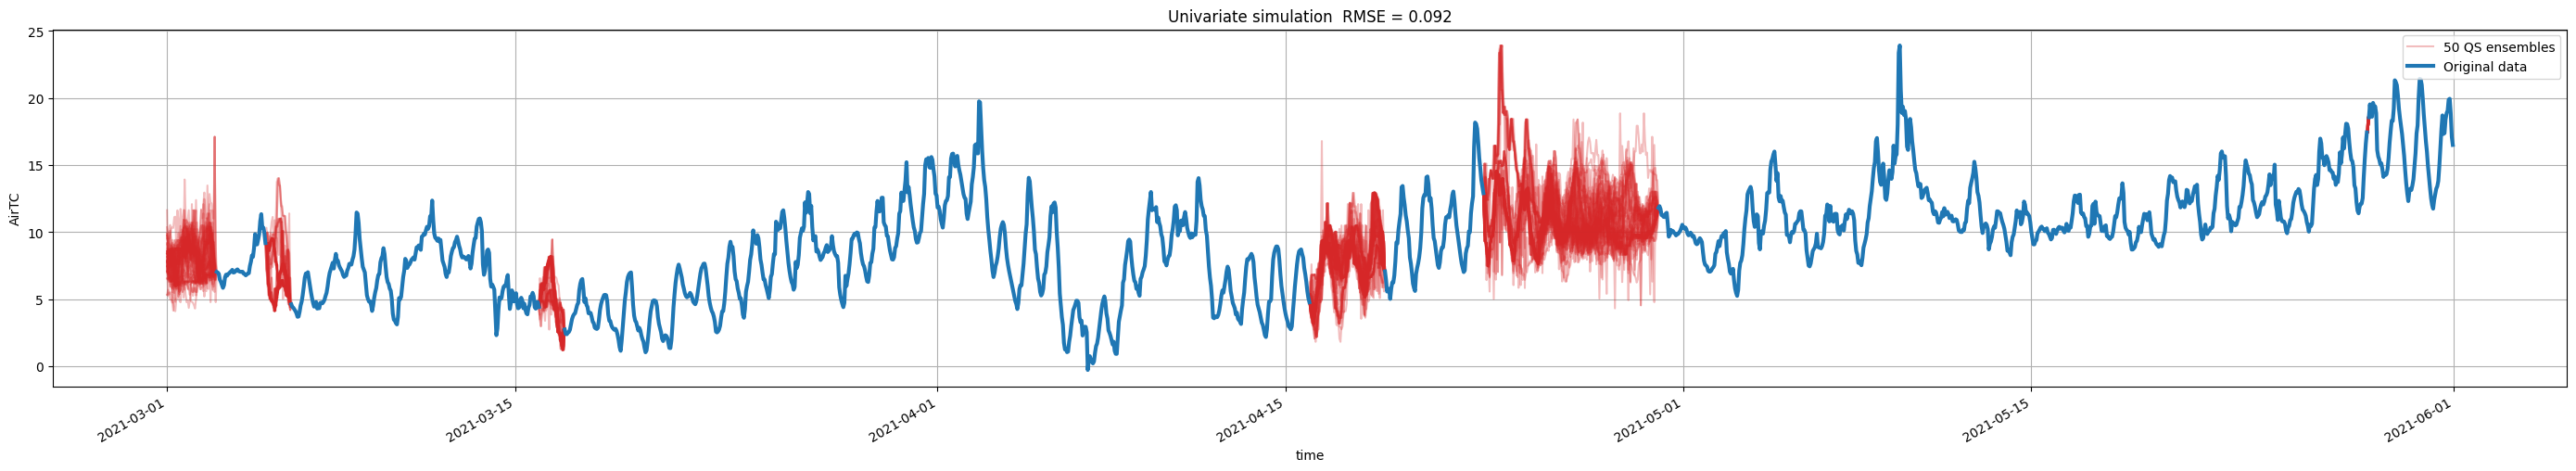

In [79]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = original,
                   simulation = UV_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Univariate simulation ')

In [80]:
corr=np.round(xr.corr(original, UV_simulations, dim="time").mean(dim="realizations").values,4)
error = np.round(np.sqrt(np.nanmean((UV_simulations.data-original.data)**2)),4)
std_ratio=(original/UV_simulations).mean(dim="realizations").mean(dim="time").values
print(corr)
print(error)
print(std_ratio)

0.9999
0.0922
0.9997253517171077


In [81]:
covar2 = era5.t2m.copy()
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


MV5_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
MV5_simulations = xr.DataArray(data =MV5_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,MV5_stacked.shape[0]+1),'time':gapped_data.time})


job Id is: 1290800597
progress 100.000%       
        job Id is: 2689084495
progress 100.000%       
        job Id is: 4069435599
progress 100.000%       
        job Id is: 1143567685
progress 100.000%       
        job Id is: 2507819600
progress 100.000%       
        job Id is: 3870484526
progress 100.000%       
        job Id is: 955878634
progress 100.000%       
        job Id is: 2312838092
progress 100.000%       
        job Id is: 3667879261
progress 100.000%       
        job Id is: 747792311
progress 100.000%       
        job Id is: 2125373540
progress 100.000%       
        job Id is: 3484242086
progress 100.000%       
        job Id is: 559767463
progress 100.000%       
        job Id is: 1944930348
progress 100.000%       
        job Id is: 3299932217
progress 100.000%       
        job Id is: 391466089
progress 100.000%       
        job Id is: 1750432033
progress 100.000%       
        job Id is: 3137194899
progress 100.000%       
        job Id is: 231

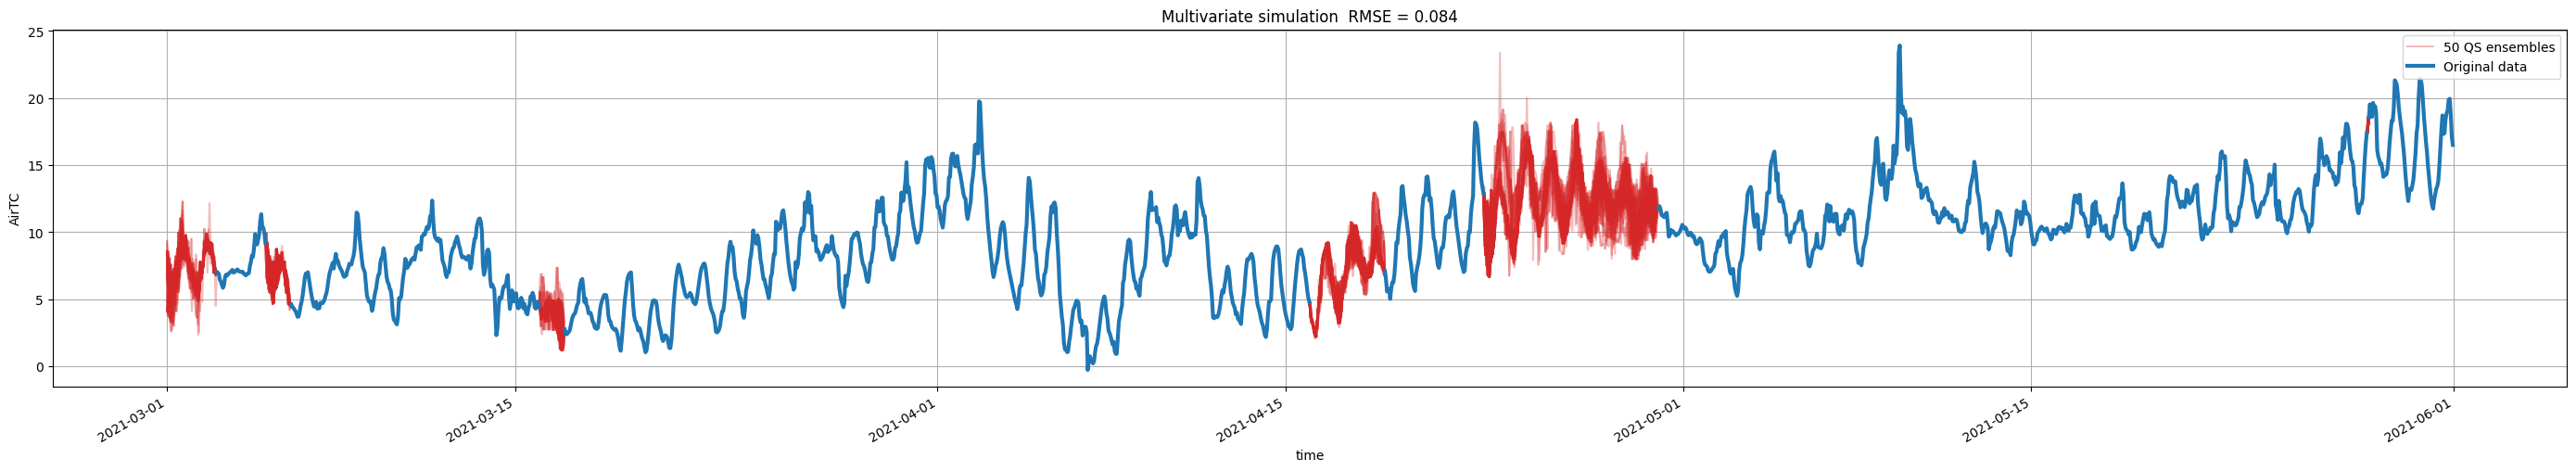

In [83]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = original,
                   simulation = MV5_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Multivariate simulation ')

In [ ]:
# still looking for a good wavelet analysis
# something easy like https://github.com/jkrasting/xwavelet/blob/main/example_usage.ipynb
# but I couldnt make that work

In [ ]:
end

In [ ]:
#why do we introduce gaps into covariables?

In [ ]:
for N in N_list:
  for gap_amount in gap_amount_list:


    for i in range(runs):

      gapped_data, gap_indices = create_gaps(original,gap_number = gap_amount)
      L = gapped_data.data.size
      sin_calendar = sin_costfunction(L,daily_timesteps = 24)
      cos_calendar = cos_costfunction(L,daily_timesteps = 24)
      timeofday = original.time.dt.hour.values #Categorical variable, the category "12pm" is as distant to the category "12am" as "6am"


      print("This is run "+str(i)+" with N="+str(N)+" and GN="+str(gap_amount))


      #Univariate gap-filling
      ti = gapped_data.data
      di = gapped_data.data
      dt = [0]

      UV_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      UV_simulations = xr.DataArray(data =UV_stacked,coords = {'realizations':np.arange(1,UV_stacked.shape[0]+1),'time':gapped_data.time})


      #Meteo AirTC with calendar day
      ti = np.stack([gapped_data.data,sin_calendar,cos_calendar],axis = 1)
      di = np.stack([gapped_data, sin_calendar,cos_calendar],axis = 1)
      dt = [0,0,0] #3 continuous variables

      MV1_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV1_simulations = xr.DataArray(data =MV1_stacked[:,:,0], 
                                    coords = {'realizations':np.arange(1,MV1_stacked.shape[0]+1),'time':gapped_data.time})

      #gap-filling with calendar day and time of day 
      ti = np.stack([gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    timeofday],axis = 1)
      di = np.stack([ gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    timeofday],axis = 1)
      #ki = np.ones([L,4])
      #ki[:,:3] = 0.5 #Assign half weight to categorical variable 
      dt = [0,0,0,1]  #time of day is a categorical variable

      MV2_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)

      MV2_simulations = xr.DataArray(data =MV2_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV2_stacked.shape[0]+1),'time':gapped_data.time})          


In [ ]:
year = 2020
start_month =6
end_month = 8

plot_MPS_ensembles(original = meteo.AirTC,
                   simulation = UV_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Univariate simulation ')

plot_MPS_ensembles(original = meteo.AirTC,
                   simulation = MV1_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Simulation with seasonality covariable ')

plot_MPS_ensembles(original = meteo.AirTC,
                   simulation = MV2_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Simulation with seasonality and time of day covariables ')

In [ ]:
N = amount_member
runs=test_runs


In [ ]:
original = meteo_orig_airtc

timeofday = meteo_orig_airtc.time.dt.hour.values #Ca

gap_amount_list=[24,48,72,96]
selector_list=[1,2,3,4]

corr_score=[]
rmse_score=[]
sd_score=[]

for j in range(runs):
    gap_locations=create_gap_index(da=meteo_orig_airtc,gap_percent=11,gap_length=24)

    for i in range(len(gap_amount_list)):
        gapped_data=create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=gap_amount_list[i],selector=selector_list[i])
        L = gapped_data.data.size
        sin_calendar = sin_costfunction(L,daily_timesteps = 24)
        cos_calendar = cos_costfunction(L,daily_timesteps = 24)
        print("This is run "+str(j)+" with N="+str(N)+" and GN="+str(gap_amount_list[i]))
    
    

In [ ]:
#Prepare data
original = meteo.AirTC




corr_score=[]
rmse_score=[]

for N in N_list:
  for gap_amount in gap_amount_list:


    for i in range(executions):

      gapped_data, gap_indices = create_gaps(original,gap_number = gap_amount)
      L = gapped_data.data.size
      sin_calendar = sin_costfunction(L)
      cos_calendar = cos_costfunction(L)
      timeofday = np.array([0,1,2,3]*np.ceil(L/4).astype(int))[:L] #Categorical variable, the category "12pm" is as distant to the category "12am" as "6am"


      print("This is run "+str(i)+" with N="+str(N)+" and GN="+str(gap_amount))


      #Univariate gap-filling
      ti = gapped_data.data
      di = gapped_data.data
      dt = [0]

      UV_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      UV_simulations = xr.DataArray(data =UV_stacked,coords = {'realizations':np.arange(1,UV_stacked.shape[0]+1),'time':gapped_data.time})


      #Meteo AirTC with calendar day
      ti = np.stack([gapped_data.data,sin_calendar,cos_calendar],axis = 1)
      di = np.stack([gapped_data, sin_calendar,cos_calendar],axis = 1)
      dt = [0,0,0] #3 continuous variables

      MV1_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV1_simulations = xr.DataArray(data =MV1_stacked[:,:,0], 
                                    coords = {'realizations':np.arange(1,MV1_stacked.shape[0]+1),'time':gapped_data.time})

      #gap-filling with calendar day and time of day 
      ti = np.stack([gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    timeofday],axis = 1)
      di = np.stack([ gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    timeofday],axis = 1)
      #ki = np.ones([L,4])
      #ki[:,:3] = 0.5 #Assign half weight to categorical variable 
      dt = [0,0,0,1]  #time of day is a categorical variable

      MV2_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)

      MV2_simulations = xr.DataArray(data =MV2_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV2_stacked.shape[0]+1),'time':gapped_data.time})          

      
      #gap-filling with calendar day and Pressure and Windspeed

      #Create gaps at the same locations as AirTC
      covar1 = meteo.BP.copy()
      covar1.loc[dict(time = covar1.time[gap_indices])] = np.nan
      covar2 = meteo.Slrw.copy()
      covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan

      ti = np.stack([gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    covar1,
                    covar2],axis = 1)
      di = np.stack([gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    covar1,
                    covar2],axis = 1)
      dt = [0,0,0,0,0] 
      #ki = np.ones([L,5])
      #ki[:,:4] = 0.3 #Assign half weight to categorical variable 


      MV3_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV3_simulations = xr.DataArray(data =MV3_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV3_stacked.shape[0]+1),'time':gapped_data.time})                      

      #gap-filling with shortwave

      #Create gaps at the same locations as AirTC

      covar2 = meteo.Slrw.copy()
      covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan

      ti = np.stack([gapped_data.data,
                    covar2],axis = 1)
      di = np.stack([gapped_data.data,
                    covar2],axis = 1)
      dt = [0,0,] 
      #ki = np.ones([L,5])
      #ki[:,:4] = 0.3 #Assign half weight to categorical variable 


      MV4_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV4_simulations = xr.DataArray(data =MV4_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV4_stacked.shape[0]+1),'time':gapped_data.time})
      
      #gap-filling with era t2m

      #Create gaps at the same locations as AirTC

      covar2 = era5_land.t2m.copy()
      covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan

      ti = np.stack([gapped_data.data,
                    covar2],axis = 1)
      di = np.stack([gapped_data.data,
                    covar2],axis = 1)
      dt = [0,0,] 
      #ki = np.ones([L,5])
      #ki[:,:4] = 0.3 #Assign half weight to categorical variable 


      MV5_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV5_simulations = xr.DataArray(data =MV5_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV5_stacked.shape[0]+1),'time':gapped_data.time})
      
        
        
        
      covar2 = era5.t2m.copy()
      covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan

      ti = np.stack([gapped_data.data,
                    covar2],axis = 1)
      di = np.stack([gapped_data.data,
                    covar2],axis = 1)
      dt = [0,0,] 
      #ki = np.ones([L,5])
      #ki[:,:4] = 0.3 #Assign half weight to categorical variable 


      MV5_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV5_simulations = xr.DataArray(data =MV5_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV5_stacked.shape[0]+1),'time':gapped_data.time})
      
      # Compute correlation between simulation and observation in the artificial gaps

      UV_corr=np.round(xr.corr(original, UV_simulations, dim="time").mean(dim="realizations").values,4)
      MV1_corr=np.round(xr.corr(original, MV1_simulations, dim="time").mean(dim="realizations").values,4)
      MV2_corr=np.round(xr.corr(original, MV2_simulations, dim="time").mean(dim="realizations").values,4)
      MV3_corr=np.round(xr.corr(original, MV3_simulations, dim="time").mean(dim="realizations").values,4)
      MV4_corr=np.round(xr.corr(original, MV4_simulations, dim="time").mean(dim="realizations").values,4)
      MV5_corr=np.round(xr.corr(original, MV5_simulations, dim="time").mean(dim="realizations").values,4)
      corr_vector=[UV_corr, MV1_corr,MV2_corr,MV3_corr,MV4_corr,MV5_corr]
      print("Correlation Skill")
      print(UV_corr, MV1_corr,MV2_corr,MV3_corr,MV4_corr,MV5_corr)

      # Compute RMSE between simulation and observation in the artificial gaps
      UV_error = np.round(np.sqrt(np.nanmean((UV_simulations.data-original.data)**2)),4)
      MV1_error = np.round(np.sqrt(np.nanmean((MV1_simulations.data-original.data)**2)),4)
      MV2_error = np.round(np.sqrt(np.nanmean((MV2_simulations.data-original.data)**2)),4)
      MV3_error = np.round(np.sqrt(np.nanmean((MV3_simulations.data-original.data)**2)),4)
      MV4_error = np.round(np.sqrt(np.nanmean((MV4_simulations.data-original.data)**2)),4)
      MV5_error = np.round(np.sqrt(np.nanmean((MV5_simulations.data-original.data)**2)),4)
      error_vector=[UV_error, MV1_error,MV2_error,MV3_error,MV4_error,MV5_error]
      print("RMSE Skill")
      print(UV_error, MV1_error,MV2_error,MV3_error,MV4_error,MV5_error)

      corr_score.append(corr_vector)
      rmse_score.append(error_vector)

print(np.asarray(corr_score).mean(axis=0))
print(np.asarray(rmse_score).mean(axis=0))